In [53]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os

from sklearn.model_selection import train_test_split

In [54]:
# Dataset Functions
##### USER-DEFINED FUNCTIONS
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_                = pd.read_csv('pbc2_cleaned.csv')

    bin_list           = ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders']
    cont_list          = ['age', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic']
    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    # num_Event       = len(np.unique(label)) - 1
    num_Event       = 1
    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi

In [55]:
# ! pip uninstall tensorflow

In [56]:
#!pip install tensorflow==1.13.1

In [57]:
# Longitudional Model Functions

from tensorflow.contrib.layers import fully_connected as FC_Net
from tensorflow.python.ops.rnn import _transpose_batch_time

def log(x):
    return tf.log(x + _EPSILON)

def div(x, y):
    return tf.div(x, (y + _EPSILON))

def get_seq_length(sequence):
    used = tf.sign(tf.reduce_max(tf.abs(sequence), 2))
    tmp_length = tf.reduce_sum(used, 1)
    tmp_length = tf.cast(tmp_length, tf.int32)
    return tmp_length


class Model_Longitudinal_Attention:
    def __init__(self, sess, name, input_dims, network_settings):
        self.sess               = sess
        self.name               = name

        # INPUT DIMENSIONS
        self.x_dim              = input_dims['x_dim']
        self.x_dim_cont         = input_dims['x_dim_cont']
        self.x_dim_bin          = input_dims['x_dim_bin']

        self.num_Event          = input_dims['num_Event']
        self.num_Category       = input_dims['num_Category']
        self.max_length         = input_dims['max_length']

        # NETWORK HYPER-PARMETERS
        self.h_dim1             = network_settings['h_dim_RNN']
        self.h_dim2             = network_settings['h_dim_FC']
        self.num_layers_RNN     = network_settings['num_layers_RNN']
        self.num_layers_ATT     = network_settings['num_layers_ATT']
        self.num_layers_CS      = network_settings['num_layers_CS']

        self.RNN_type           = network_settings['RNN_type']

        self.FC_active_fn       = network_settings['FC_active_fn']
        self.RNN_active_fn      = network_settings['RNN_active_fn']
        self.initial_W          = network_settings['initial_W']
        
        self.reg_W              = tf.contrib.layers.l1_regularizer(scale=network_settings['reg_W'])
        self.reg_W_out          = tf.contrib.layers.l1_regularizer(scale=network_settings['reg_W_out'])

        self._build_net()


    def _build_net(self):
        with tf.variable_scope(self.name):
            #### PLACEHOLDER DECLARATION
            self.mb_size     = tf.placeholder(tf.int32, [], name='batch_size')

            self.lr_rate     = tf.placeholder(tf.float32)
            self.keep_prob   = tf.placeholder(tf.float32)                                                      #keeping rate
            self.a           = tf.placeholder(tf.float32)
            self.b           = tf.placeholder(tf.float32)
            self.c           = tf.placeholder(tf.float32)

            self.x           = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim])
            self.x_mi        = tf.placeholder(tf.float32, shape=[None, self.max_length, self.x_dim])           #this is the missing indicator (including for cont. & binary) (includes delta)
            self.k           = tf.placeholder(tf.float32, shape=[None, 1])                                     #event/censoring label (censoring:0)
            self.t           = tf.placeholder(tf.float32, shape=[None, 1])


            self.fc_mask1    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category])     #for denominator
            self.fc_mask2    = tf.placeholder(tf.float32, shape=[None, self.num_Event, self.num_Category])     #for Loss 1
            self.fc_mask3    = tf.placeholder(tf.float32, shape=[None, self.num_Category])                     #for Loss 2

            
            seq_length     = get_seq_length(self.x)
            tmp_range      = tf.expand_dims(tf.range(0, self.max_length, 1), axis=0)
            
            self.rnn_mask1 = tf.cast(tf.less_equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32)            
            self.rnn_mask2 = tf.cast(tf.equal(tmp_range, tf.expand_dims(seq_length - 1, axis=1)), tf.float32) 
            
            
            ### DEFINE LOOP FUNCTION FOR RAW_RNN w/ TEMPORAL ATTENTION
            def loop_fn_att(time, cell_output, cell_state, loop_state):

                emit_output = cell_output 

                if cell_output is None:  # time == 0
                    next_cell_state = cell.zero_state(self.mb_size, tf.float32)
                    next_loop_state = loop_state_ta
                else:
                    next_cell_state = cell_state
                    tmp_h = create_concat_state(next_cell_state, self.num_layers_RNN, self.RNN_type)

                    e = create_FCNet(tf.concat([tmp_h, all_last], axis=1), self.num_layers_ATT, self.h_dim2, 
                                           tf.nn.tanh, 1, None, self.initial_W, keep_prob=self.keep_prob)
                    e = tf.exp(e)

                    next_loop_state = (loop_state[0].write(time-1, e),                # save att power (e_{j})
                                       loop_state[1].write(time-1, tmp_h))  # save all the hidden states

                # elements_finished = (time >= seq_length)
                elements_finished = (time >= self.max_length-1)

                #this gives the break-point (no more recurrence after the max_length)
                finished = tf.reduce_all(elements_finished)    
                next_input = tf.cond(finished, lambda: tf.zeros([self.mb_size, 2*self.x_dim], dtype=tf.float32),  # [x_hist, mi_hist]
                                               lambda: inputs_ta.read(time))

                return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)


            
            # divide into the last x and previous x's
            x_last = tf.slice(self.x, [0,(self.max_length-1), 1], [-1,-1,-1])      #current measurement
            x_last = tf.reshape(x_last, [-1, (self.x_dim_cont+self.x_dim_bin)])    #remove the delta of the last measurement

            x_last = tf.reduce_sum(tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]) * self.x, reduction_indices=1)    #sum over time since all others time stamps are 0
            x_last = tf.slice(x_last, [0,1], [-1,-1])                               #remove the delta of the last measurement
            x_hist = self.x * (1.-tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]))                                    #since all others time stamps are 0 and measurements are 0-padded
            x_hist = tf.slice(x_hist, [0, 0, 0], [-1,(self.max_length-1),-1])  

            # do same thing for missing indicator
            mi_last = tf.slice(self.x_mi, [0,(self.max_length-1), 1], [-1,-1,-1])      #current measurement
            mi_last = tf.reshape(mi_last, [-1, (self.x_dim_cont+self.x_dim_bin)])    #remove the delta of the last measurement

            mi_last = tf.reduce_sum(tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]) * self.x_mi, reduction_indices=1)    #sum over time since all others time stamps are 0
            mi_last = tf.slice(mi_last, [0,1], [-1,-1])                               #remove the delta of the last measurement
            mi_hist = self.x_mi * (1.-tf.tile(tf.expand_dims(self.rnn_mask2, axis=2), [1,1,self.x_dim]))                                    #since all others time stamps are 0 and measurements are 0-padded
            mi_hist = tf.slice(mi_hist, [0, 0, 0], [-1,(self.max_length-1),-1])  

            all_hist = tf.concat([x_hist, mi_hist], axis=2)
            all_last = tf.concat([x_last, mi_last], axis=1)


            #extract inputs for the temporal attention: mask (to incorporate only the measured time) and x_{M}
            seq_length     = get_seq_length(x_hist)
            rnn_mask_att   = tf.cast(tf.not_equal(tf.reduce_sum(x_hist, reduction_indices=2), 0), dtype=tf.float32)  #[mb_size, max_length-1], 1:measurements 0:no measurements
            

            ##### SHARED SUBNETWORK: RNN w/ TEMPORAL ATTENTION
            #change the input tensor to TensorArray format with [max_length, mb_size, x_dim]
            inputs_ta = tf.TensorArray(dtype=tf.float32, size=self.max_length-1).unstack(_transpose_batch_time(all_hist), name = 'Shared_Input')


            #create a cell with RNN hyper-parameters (RNN types, #layers, #nodes, activation functions, keep proability)
            cell = create_rnn_cell(self.h_dim1, self.num_layers_RNN, self.keep_prob, 
                                         self.RNN_type, self.RNN_active_fn)

            #define the loop_state TensorArray for information from rnn time steps
            loop_state_ta = (tf.TensorArray(size=self.max_length-1, dtype=tf.float32),  #e values (e_{j})
                             tf.TensorArray(size=self.max_length-1, dtype=tf.float32))  #hidden states (h_{j})
            
            rnn_outputs_ta, self.rnn_final_state, loop_state_ta = tf.nn.raw_rnn(cell, loop_fn_att)
            #rnn_outputs_ta  : TensorArray
            #rnn_final_state : Tensor
            #rnn_states_ta   : (TensorArray, TensorArray)

            rnn_outputs = _transpose_batch_time(rnn_outputs_ta.stack())
            # rnn_outputs =  tf.reshape(rnn_outputs, [-1, self.max_length-1, self.h_dim1])

            rnn_states  = _transpose_batch_time(loop_state_ta[1].stack())

            att_weight  = _transpose_batch_time(loop_state_ta[0].stack()) #e_{j}
            att_weight  = tf.reshape(att_weight, [-1, self.max_length-1]) * rnn_mask_att # masking to set 0 for the unmeasured e_{j}

            #get a_{j} = e_{j}/sum_{l=1}^{M-1}e_{l}
            self.att_weight  = div(att_weight,(tf.reduce_sum(att_weight, axis=1, keepdims=True) + _EPSILON)) #softmax (tf.exp is done, previously)

            # 1) expand att_weight to hidden state dimension, 2) c = \sum_{j=1}^{M} a_{j} x h_{j}
            self.context_vec = tf.reduce_sum(tf.tile(tf.reshape(self.att_weight, [-1, self.max_length-1, 1]), [1, 1, self.num_layers_RNN*self.h_dim1]) * rnn_states, axis=1)


            self.z_mean      = FC_Net(rnn_outputs, self.x_dim, activation_fn=None, weights_initializer=self.initial_W, scope="RNN_out_mean1")
            self.z_std       = tf.exp(FC_Net(rnn_outputs, self.x_dim, activation_fn=None, weights_initializer=self.initial_W, scope="RNN_out_std1"))

            epsilon          = tf.random_normal([self.mb_size, self.max_length-1, self.x_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
            self.z           = self.z_mean + self.z_std * epsilon

            
            ##### CS-SPECIFIC SUBNETWORK w/ FCNETS 
            inputs = tf.concat([x_last, self.context_vec], axis=1)


            #1 layer for combining inputs
            h = FC_Net(inputs, self.h_dim2, activation_fn=self.FC_active_fn, weights_initializer=self.initial_W, scope="Layer1")
            h = tf.nn.dropout(h, keep_prob=self.keep_prob)

            # (num_layers_CS-1) layers for cause-specific (num_Event subNets)
            out = []
            for _ in range(self.num_Event):
                cs_out = create_FCNet(h, (self.num_layers_CS), self.h_dim2, self.FC_active_fn, self.h_dim2, self.FC_active_fn, self.initial_W, self.reg_W, self.keep_prob)
                out.append(cs_out)
            out = tf.stack(out, axis=1) # stack referenced on subject
            out = tf.reshape(out, [-1, self.num_Event*self.h_dim2])
            out = tf.nn.dropout(out, keep_prob=self.keep_prob)

            out = FC_Net(out, self.num_Event * self.num_Category, activation_fn=tf.nn.softmax, 
                         weights_initializer=self.initial_W, weights_regularizer=self.reg_W_out, scope="Output")
            self.out = tf.reshape(out, [-1, self.num_Event, self.num_Category])


            ##### GET LOSS FUNCTIONS
            self.loss_Log_Likelihood()      #get loss1: Log-Likelihood loss
            self.loss_Ranking()             #get loss2: Ranking loss
            self.loss_RNN_Prediction()      #get loss3: RNN prediction loss

            self.LOSS_TOTAL     = self.a*self.LOSS_1 + self.b*self.LOSS_2 + self.c*self.LOSS_3 + tf.losses.get_regularization_loss()
            self.LOSS_BURNIN    = self.LOSS_3 + tf.losses.get_regularization_loss()

            self.solver         = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_TOTAL)
            self.solver_burn_in = tf.train.AdamOptimizer(learning_rate=self.lr_rate).minimize(self.LOSS_BURNIN)


    ### LOSS-FUNCTION 1 -- Log-likelihood loss
    def loss_Log_Likelihood(self):
        sigma3 = tf.constant(1.0, dtype=tf.float32)

        I_1 = tf.sign(self.k)
        denom = 1 - tf.reduce_sum(tf.reduce_sum(self.fc_mask1 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True) # make subject specific denom.
        denom = tf.clip_by_value(denom, tf.cast(_EPSILON, dtype=tf.float32), tf.cast(1.-_EPSILON, dtype=tf.float32))

        #for uncenosred: log P(T=t,K=k|x,Y,t>t_M)
        tmp1 = tf.reduce_sum(tf.reduce_sum(self.fc_mask2 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp1 = I_1 * log(div(tmp1,denom))

        #for censored: log \sum P(T>t|x,Y,t>t_M)
        tmp2 = tf.reduce_sum(tf.reduce_sum(self.fc_mask2 * self.out, reduction_indices=2), reduction_indices=1, keepdims=True)
        tmp2 = (1. - I_1) * log(div(tmp2,denom))

        self.LOSS_1 = - tf.reduce_mean(tmp1 + sigma3*tmp2)


    ### LOSS-FUNCTION 2 -- Ranking loss
    def loss_Ranking(self):
        sigma1 = tf.constant(0.1, dtype=tf.float32)

        eta = []
        for e in range(self.num_Event):
            one_vector = tf.ones_like(self.t, dtype=tf.float32)
            I_2 = tf.cast(tf.equal(self.k, e+1), dtype = tf.float32) #indicator for event
            I_2 = tf.diag(tf.squeeze(I_2))
            tmp_e = tf.reshape(tf.slice(self.out, [0, e, 0], [-1, 1, -1]), [-1, self.num_Category]) #event specific joint prob.

            R = tf.matmul(tmp_e, tf.transpose(self.fc_mask3)) #no need to divide by each individual dominator
            # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

            diag_R = tf.reshape(tf.diag_part(R), [-1, 1])
            R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
            R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

            T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(self.t)) - tf.matmul(self.t, tf.transpose(one_vector))))
            # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

            T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

            tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), reduction_indices=1, keepdims=True)

            eta.append(tmp_eta)
        eta = tf.stack(eta, axis=1) #stack referenced on subjects
        eta = tf.reduce_mean(tf.reshape(eta, [-1, self.num_Event]), reduction_indices=1, keepdims=True)

        self.LOSS_2 = tf.reduce_sum(eta) #sum over num_Events


    ### LOSS-FUNCTION 3 -- RNN prediction loss
    def loss_RNN_Prediction(self):
        tmp_x  = tf.slice(self.x, [0,1,0], [-1,-1,-1])  # (t=2 ~ M)
        tmp_mi = tf.slice(self.x_mi, [0,1,0], [-1,-1,-1])  # (t=2 ~ M)

        tmp_mask1  = tf.tile(tf.expand_dims(self.rnn_mask1, axis=2), [1,1,self.x_dim]) #for hisotry (1...J-1)
        tmp_mask1  = tmp_mask1[:, :(self.max_length-1), :] 

        zeta = tf.reduce_mean(tf.reduce_sum(tmp_mask1 * (1. - tmp_mi) * tf.pow(self.z - tmp_x, 2), reduction_indices=1))  #loss calculated for selected features.

        self.LOSS_3 = zeta

 
    def get_cost(self, DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (m1_mb, m2_mb, m3_mb)     = MASK
        (x_mi_mb)                 = MISSING
        (alpha, beta, gamma)      = PARAMETERS
        return self.sess.run(self.LOSS_TOTAL, 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb, 
                                        self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, self.fc_mask3: m3_mb, 
                                        self.a:alpha, self.b:beta, self.c:gamma,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})

    def train(self, DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (m1_mb, m2_mb, m3_mb)     = MASK
        (x_mi_mb)                 = MISSING
        (alpha, beta, gamma)      = PARAMETERS
        return self.sess.run([self.solver, self.LOSS_TOTAL], 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb,
                                        self.fc_mask1: m1_mb, self.fc_mask2:m2_mb, self.fc_mask3: m3_mb, 
                                        self.a:alpha, self.b:beta, self.c:gamma,
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def train_burn_in(self, DATA, MISSING, keep_prob, lr_train):
        (x_mb, k_mb, t_mb)        = DATA
        (x_mi_mb)                 = MISSING

        return self.sess.run([self.solver_burn_in, self.LOSS_3], 
                             feed_dict={self.x:x_mb, self.x_mi: x_mi_mb, self.k:k_mb, self.t:t_mb, 
                                        self.mb_size: np.shape(x_mb)[0], self.keep_prob:keep_prob, self.lr_rate:lr_train})
    
    def predict(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.out, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_z(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.z, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_rnnstate(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.rnn_final_state, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_att(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.att_weight, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def predict_context_vec(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run(self.context_vec, feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

    def get_z_mean_and_std(self, x_test, x_mi_test, keep_prob=1.0):
        return self.sess.run([self.z_mean, self.z_std], feed_dict={self.x: x_test, self.x_mi: x_mi_test, self.mb_size: np.shape(x_test)[0], self.keep_prob: keep_prob})

In [58]:
# Utility Functions

from tensorflow.contrib.layers import fully_connected as FC_Net


### CONSTRUCT MULTICELL FOR MULTI-LAYER RNNS
def create_rnn_cell(num_units, num_layers, keep_prob, RNN_type, activation_fn): 
    '''
        GOAL         : create multi-cell (including a single cell) to construct multi-layer RNN
        num_units    : number of units in each layer
        num_layers   : number of layers in MulticellRNN
        keep_prob    : keep probabilty [0, 1]  (if None, dropout is not employed)
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    if activation_fn == 'None':
        activation_fn = tf.nn.tanh

    cells = []
    for _ in range(num_layers):
        if RNN_type == 'GRU':
            cell = tf.contrib.rnn.GRUCell(num_units, activation=activation_fn)
        elif RNN_type == 'LSTM':
            cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn, state_is_tuple=True)
            # cell = tf.contrib.rnn.LSTMCell(num_units, activation=activation_fn)
        if not keep_prob is None:
            cell = tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob) # state_keep_prob=keep_prob
        cells.append(cell)
    cell = tf.contrib.rnn.MultiRNNCell(cells)
    
    return cell


### EXTRACT STATE OUTPUT OF MULTICELL-RNNS
def create_concat_state(state, num_layers, RNN_type, BiRNN=None):
    '''
        GOAL	     : concatenate the tuple-type tensor (state) into a single tensor
        state        : input state is a tuple ofo MulticellRNN (i.e. output of MulticellRNN)
                       consist of only hidden states h for GRU and hidden states c and h for LSTM
        num_layers   : number of layers in MulticellRNN
        RNN_type     : either 'LSTM' or 'GRU'
    '''
    for i in range(num_layers):
        if BiRNN != None:
            if RNN_type == 'LSTM':
                tmp = tf.concat([state[0][i][1], state[1][i][1]], axis=1) ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = tf.concat([state[0][i], state[1][i]], axis=1) ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')
        else:
            if RNN_type == 'LSTM':
                tmp = state[i][1] ## i-th layer, h state for LSTM
            elif RNN_type == 'GRU':
                tmp = state[i] ## i-th layer, h state for GRU
            else:
                print('ERROR: WRONG RNN CELL TYPE')

        if i == 0:
            rnn_state_out = tmp
        else:
            rnn_state_out = tf.concat([rnn_state_out, tmp], axis = 1)
    
    return rnn_state_out


### FEEDFORWARD NETWORK
def create_FCNet(inputs, num_layers, h_dim, h_fn, o_dim, o_fn, w_init, w_reg=None, keep_prob=1.0):
    '''
        GOAL             : Create FC network with different specifications 
        inputs (tensor)  : input tensor
        num_layers       : number of layers in FCNet
        h_dim  (int)     : number of hidden units
        h_fn             : activation function for hidden layers (default: tf.nn.relu)
        o_dim  (int)     : number of output units
        o_fn             : activation function for output layers (defalut: None)
        w_init           : initialization for weight matrix (defalut: Xavier)
        keep_prob        : keep probabilty [0, 1]  (if None, dropout is not employed)
    '''
    # default active functions (hidden: relu, out: None)
    if h_fn is None:
        h_fn = tf.nn.relu
    if o_fn is None:
        o_fn = None

    # default initialization functions (weight: Xavier, bias: None)
    if w_init is None:
        w_init = tf.contrib.layers.xavier_initializer() # Xavier initialization

    for layer in range(num_layers):
        if num_layers == 1:
            out = FC_Net(inputs, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)
        else:
            if layer == 0:
                h = FC_Net(inputs, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            elif layer > 0 and layer != (num_layers-1): # layer > 0:
                h = FC_Net(h, h_dim, activation_fn=h_fn, weights_initializer=w_init, weights_regularizer=w_reg)
                if not keep_prob is None:
                    h = tf.nn.dropout(h, keep_prob=keep_prob)

            else: # layer == num_layers-1 (the last layer)
                out = FC_Net(h, o_dim, activation_fn=o_fn, weights_initializer=w_init, weights_regularizer=w_reg)

    return out

In [59]:
# Helper Functions

import random

##### USER-DEFINED FUNCTIONS
def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask1 is required to get the contional probability (to calculate the denominator part)
        mask1 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask

def f_get_minibatch(mb_size, x, x_mi, label, time, mask1, mask2, mask3):
    idx = range(np.shape(x)[0])
    idx = random.sample(idx, mb_size)

    x_mb     = x[idx, :, :].astype(float)
    x_mi_mb  = x_mi[idx, :, :].astype(float)
    k_mb     = label[idx, :].astype(float) # censoring(0)/event(1,2,..) label
    t_mb     = time[idx, :].astype(float)
    m1_mb    = mask1[idx, :, :].astype(float) #fc_mask
    m2_mb    = mask2[idx, :, :].astype(float) #fc_mask
    m3_mb    = mask3[idx, :].astype(float) #fc_mask
    return x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb


def f_get_boosted_trainset(x, x_mi, time, label, mask1, mask2, mask3):
    _, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
    meas_time = np.concatenate([np.zeros([np.shape(x)[0], 1]), np.cumsum(x[:, :, 0], axis=1)[:, :-1]], axis=1)

    total_sample = 0
    for i in range(np.shape(x)[0]):
        total_sample += np.sum(np.sum(x[i], axis=1) != 0)

    new_label          = np.zeros([total_sample, np.shape(label)[1]])
    new_time           = np.zeros([total_sample, np.shape(time)[1]])
    new_x              = np.zeros([total_sample, np.shape(x)[1], np.shape(x)[2]])
    new_x_mi           = np.zeros([total_sample, np.shape(x_mi)[1], np.shape(x_mi)[2]])
    new_mask1          = np.zeros([total_sample, np.shape(mask1)[1], np.shape(mask1)[2]])
    new_mask2          = np.zeros([total_sample, np.shape(mask2)[1], np.shape(mask2)[2]])
    new_mask3          = np.zeros([total_sample, np.shape(mask3)[1]])

    tmp_idx = 0
    for i in range(np.shape(x)[0]):
        max_meas = np.sum(np.sum(x[i], axis=1) != 0)

        for t in range(max_meas):
            new_label[tmp_idx+t, 0] = label[i,0]
            new_time[tmp_idx+t, 0]  = time[i,0]

            new_x[tmp_idx+t,:(t+1), :] = x[i,:(t+1), :]
            new_x_mi[tmp_idx+t,:(t+1), :] = x_mi[i,:(t+1), :]

            new_mask1[tmp_idx+t, :, :] = f_get_fc_mask1(meas_time[i,t].reshape([-1,1]), num_Event, num_Category) #age at the measurement
            new_mask2[tmp_idx+t, :, :] = mask2[i, :, :]
            new_mask3[tmp_idx+t, :]    = mask3[i, :]

        tmp_idx += max_meas
        
    return(new_x, new_x_mi, new_time, new_label, new_mask1, new_mask2, new_mask3)


In [60]:
# Logging Functions (Not Important)
def save_logging(dictionary, log_name):
    with open(log_name, 'w') as f:
        for key, value in dictionary.items():
            f.write('%s:%s\n' % (key, value))


def load_logging(filename):
    data = dict()
    with open(filename) as f:
        def is_float(input):
            try:
                num = float(input)
            except ValueError:
                return False
            return True

        for line in f.readlines():
            if ':' in line:
                key,value = line.strip().split(':', 1)
                if value.isdigit():
                    data[key] = int(value)
                elif is_float(value):
                    data[key] = float(value)
                elif value == 'None':
                    data[key] = None
                else:
                    data[key] = value
            else:
                pass # deal with bad lines of text here    
    return data

In [61]:
#! pip install lifelines

In [62]:
# Evalutation Functions
import numpy as np
from lifelines import KaplanMeierFitter


### C(t)-INDEX CALCULATION
def c_index(Prediction, Time_survival, Death, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        A[i, np.where(Time_survival[i] < Time_survival)] = 1
        Q[i, np.where(Prediction[i] > Prediction)] = 1
  
        if (Time_survival[i]<=Time and Death[i]==1):
            N_t[i,:] = 1

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result

### BRIER-SCORE
def brier_score(Prediction, Time_survival, Death, Time):
    N = len(Prediction)
    y_true = ((Time_survival <= Time) * Death).astype(float)

    return np.mean((Prediction - y_true)**2)

    # result2[k, t] = brier_score_loss(risk[:, k], ((te_time[:,0] <= eval_horizon) * (te_label[:,0] == k+1)).astype(int))


##### WEIGHTED C-INDEX & BRIER-SCORE
def CensoringProb(Y, T):

    T = T.reshape([-1]) # (N,) - np array
    Y = Y.reshape([-1]) # (N,) - np array

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=(Y==0).astype(int))  # censoring prob = survival probability of event "censoring"
    G = np.asarray(kmf.survival_function_.reset_index()).transpose()
    G[1, G[1, :] == 0] = G[1, G[1, :] != 0][-1]  #fill 0 with ZoH (to prevent nan values)
    
    return G



### C(t)-INDEX CALCULATION
def weighted_c_index(T_train, Y_train, Prediction, T_test, Y_test, Time):
    '''
        This is a cause-specific c(t)-index
        - Prediction      : risk at Time (higher --> more risky)
        - Time_survival   : survival/censoring time
        - Death           :
            > 1: death
            > 0: censored (including death from other cause)
        - Time            : time of evaluation (time-horizon when evaluating C-index)
    '''
    G = CensoringProb(Y_train, T_train)

    N = len(Prediction)
    A = np.zeros((N,N))
    Q = np.zeros((N,N))
    N_t = np.zeros((N,N))
    Num = 0
    Den = 0
    for i in range(N):
        tmp_idx = np.where(G[0,:] >= T_test[i])[0]

        if len(tmp_idx) == 0:
            W = (1./G[1, -1])**2
        else:
            W = (1./G[1, tmp_idx[0]])**2

        A[i, np.where(T_test[i] < T_test)] = 1. * W
        Q[i, np.where(Prediction[i] > Prediction)] = 1. # give weights

        if (T_test[i]<=Time and Y_test[i]==1):
            N_t[i,:] = 1.

    Num  = np.sum(((A)*N_t)*Q)
    Den  = np.sum((A)*N_t)

    if Num == 0 and Den == 0:
        result = -1 # not able to compute c-index!
    else:
        result = float(Num/Den)

    return result


def weighted_brier_score(T_train, Y_train, Prediction, T_test, Y_test, Time):
    G = CensoringProb(Y_train, T_train)
    N = len(Prediction)

    W = np.zeros(len(Y_test))
    Y_tilde = (T_test > Time).astype(float)

    for i in range(N):
        tmp_idx1 = np.where(G[0,:] >= T_test[i])[0]
        tmp_idx2 = np.where(G[0,:] >= Time)[0]

        if len(tmp_idx1) == 0:
            G1 = G[1, -1]
        else:
            G1 = G[1, tmp_idx1[0]]

        if len(tmp_idx2) == 0:
            G2 = G[1, -1]
        else:
            G2 = G[1, tmp_idx2[0]]
        W[i] = (1. - Y_tilde[i])*float(Y_test[i])/G1 + Y_tilde[i]/G2

    y_true = ((T_test <= Time) * Y_test).astype(float)

    return np.mean(W*(Y_tilde - (1.-Prediction))**2)

In [63]:
def _f_get_pred(sess, model, data, data_mi, pred_horizon):
    '''
        predictions based on the prediction time.
        create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
    '''
    new_data    = np.zeros(np.shape(data))
    new_data_mi = np.zeros(np.shape(data_mi))

    meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)

    for i in range(np.shape(data)[0]):
        last_meas = np.sum(meas_time[i, :] <= pred_horizon)

        new_data[i, :last_meas, :]    = data[i, :last_meas, :]
        new_data_mi[i, :last_meas, :] = data_mi[i, :last_meas, :]

    return model.predict(new_data, new_data_mi)


def f_get_risk_predictions(sess, model, data_, data_mi_, pred_time, eval_time):
    
    pred = _f_get_pred(sess, model, data_[[0]], data_mi_[[0]], 0)
    _, num_Event, num_Category = np.shape(pred)
       
    risk_all = {}
    for k in range(num_Event):
        risk_all[k] = np.zeros([np.shape(data_)[0], len(pred_time), len(eval_time)])
            
    for p, p_time in enumerate(pred_time):
        ### PREDICTION
        pred_horizon = int(p_time)
        pred = _f_get_pred(sess, model, data_, data_mi_, pred_horizon)


        for t, t_time in enumerate(eval_time):
            eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
            risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
            for k in range(num_Event):
                risk_all[k][:, p, t] = risk[:, k]
                
    return risk_all

$F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)$

In [64]:
data_mode                   = 'PBC2' 
seed                        = 1234

##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (1 + num_features)
    x_dim_cont              = dim of continuous features
    x_dim_bin               = dim of binary features
    mask1, mask2, mask3     = used for cause-specific network (FCNet structure)
'''

if data_mode == 'PBC2':
    (x_dim, x_dim_cont, x_dim_bin), (data, time, label), (mask1, mask2, mask3), (data_mi) = import_dataset(norm_mode = 'standard')
    
    # This must be changed depending on the datasets, prediction/evaliation times of interest
    pred_time = [52, 3*52, 5*52] # prediction time (in months)
    eval_time = [12, 36, 60, 120] # months evaluation time (for C-index and Brier-Score)
else:
    print ('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


file_path = '{}'.format(data_mode)

if not os.path.exists(file_path):
    os.makedirs(file_path)

In [65]:
urn_in_mode                = 'ON' #{'ON', 'OFF'}
boost_mode                  = 'ON' #{'ON', 'OFF'}

##### HYPER-PARAMETERS
new_parser = {'mb_size': 32,

             'iteration_burn_in': 3000,
             'iteration': 25000,

             'keep_prob': 0.6,
             'lr_train': 1e-4,

             'h_dim_RNN': 100,
             'h_dim_FC' : 100,
             'num_layers_RNN':2,
             'num_layers_ATT':2,
             'num_layers_CS' :2,

             'RNN_type':'LSTM', #{'LSTM', 'GRU'}

             'FC_active_fn' : tf.nn.relu,
             'RNN_active_fn': tf.nn.tanh,

            'reg_W'         : 1e-5,
            'reg_W_out'     : 0.,

             'alpha' :1.0,
             'beta'  :0.1,
             'gamma' :1.0
}


# INPUT DIMENSIONS
input_dims                  = { 'x_dim'         : x_dim,
                                'x_dim_cont'    : x_dim_cont,
                                'x_dim_bin'     : x_dim_bin,
                                'num_Event'     : num_Event,
                                'num_Category'  : num_Category,
                                'max_length'    : max_length }

# NETWORK HYPER-PARMETERS
network_settings            = { 'h_dim_RNN'         : new_parser['h_dim_RNN'],
                                'h_dim_FC'          : new_parser['h_dim_FC'],
                                'num_layers_RNN'    : new_parser['num_layers_RNN'],
                                'num_layers_ATT'    : new_parser['num_layers_ATT'],
                                'num_layers_CS'     : new_parser['num_layers_CS'],
                                'RNN_type'          : new_parser['RNN_type'],
                                'FC_active_fn'      : new_parser['FC_active_fn'],
                                'RNN_active_fn'     : new_parser['RNN_active_fn'],
                                'initial_W'         : tf.contrib.layers.xavier_initializer(),

                                'reg_W'             : new_parser['reg_W'],
                                'reg_W_out'         : new_parser['reg_W_out']
                                 }


mb_size           = new_parser['mb_size']
iteration         = new_parser['iteration']
iteration_burn_in = new_parser['iteration_burn_in']

keep_prob         = new_parser['keep_prob']
lr_train          = new_parser['lr_train']

alpha             = new_parser['alpha']
beta              = new_parser['beta']
gamma             = new_parser['gamma']

# SAVE HYPERPARAMETERS
log_name = file_path + '/hyperparameters_log.txt'
save_logging(new_parser, log_name)

In [66]:
### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = train_test_split(data, data_mi, time, label, mask1, mask2, mask3, test_size=0.2, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, 
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3, test_size=0.2, random_state=seed) 

if boost_mode == 'ON':
    tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3 = f_get_boosted_trainset(tr_data, tr_data_mi, tr_time, tr_label, tr_mask1, tr_mask2, tr_mask3)

In [67]:
##### CREATE DYNAMIC-DEEPFHT NETWORK
tf.reset_default_graph()

burn_in_mode = "ON"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

model = Model_Longitudinal_Attention(sess, "Dyanmic-DeepHit", input_dims, network_settings)
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

 
### TRAINING - BURN-IN
if burn_in_mode == 'ON':
    print( "BURN-IN TRAINING ...")
    for itr in range(iteration_burn_in):
        x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
        DATA = (x_mb, k_mb, t_mb)
        MISSING = (x_mi_mb)

        _, loss_curr = model.train_burn_in(DATA, MISSING, keep_prob, lr_train)

        if (itr+1)%1000 == 0:
            print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))


### TRAINING - MAIN
print( "MAIN TRAINING ...")
min_valid = 0.5

for itr in range(iteration):
    x_mb, x_mi_mb, k_mb, t_mb, m1_mb, m2_mb, m3_mb = f_get_minibatch(mb_size, tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)
    DATA = (x_mb, k_mb, t_mb)
    MASK = (m1_mb, m2_mb, m3_mb)
    MISSING = (x_mi_mb)
    PARAMETERS = (alpha, beta, gamma)

    _, loss_curr = model.train(DATA, MASK, MISSING, PARAMETERS, keep_prob, lr_train)

    if (itr+1)%1000 == 0:
        print('itr: {:04d} | loss: {:.4f}'.format(itr+1, loss_curr))

    ### VALIDATION  (based on average C-index of our interest)
    if (itr+1)%1000 == 0:        
        risk_all = f_get_risk_predictions(sess, model, va_data, va_data_mi, pred_time, eval_time)
        
        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            val_result1 = np.zeros([num_Event, len(eval_time)])
            
            for t, t_time in enumerate(eval_time):                
                eval_horizon = int(t_time) + pred_horizon
                for k in range(num_Event):
                    val_result1[k, t] = c_index(risk_all[k][:, p, t], va_time, (va_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
            
            if p == 0:
                val_final1 = val_result1
            else:
                val_final1 = np.append(val_final1, val_result1, axis=0)

        tmp_valid = np.mean(val_final1)

        if tmp_valid >  min_valid:
            min_valid = tmp_valid
            saver.save(sess, file_path + '/model')
            print( 'updated.... average c-index = ' + str('%.4f' %(tmp_valid)))

INFO:tensorflow:Scale of 0 disables regularizer.
BURN-IN TRAINING ...
itr: 1000 | loss: 311.6709
itr: 2000 | loss: 159.9081
itr: 3000 | loss: 198.2345
MAIN TRAINING ...
itr: 1000 | loss: 183.1167
updated.... average c-index = 0.7391
itr: 2000 | loss: 97.1676
updated.... average c-index = 0.7986
itr: 3000 | loss: 84.7476
updated.... average c-index = 0.8343
itr: 4000 | loss: 135.4168
itr: 5000 | loss: 41.5561
itr: 6000 | loss: 110.4650
updated.... average c-index = 0.8530
itr: 7000 | loss: 49.9428
itr: 8000 | loss: 148.4012
itr: 9000 | loss: 57.5544
itr: 10000 | loss: 108.6998
itr: 11000 | loss: 38.5790
itr: 12000 | loss: 37.7476
itr: 13000 | loss: 58.6359
itr: 14000 | loss: 98.4904
itr: 15000 | loss: 65.6847
itr: 16000 | loss: 61.6053
itr: 17000 | loss: 86.1334
itr: 18000 | loss: 85.1382
itr: 19000 | loss: 211.7210
itr: 20000 | loss: 90.1041
itr: 21000 | loss: 67.0435
itr: 22000 | loss: 50.9932
itr: 23000 | loss: 66.8991
itr: 24000 | loss: 172.3137
itr: 25000 | loss: 186.9820


In [68]:
saver.restore(sess, file_path + '/model')

# risk_all = f_get_risk_predictions(sess, model, te_data, te_data_mi, pred_time, eval_time)

# for p, p_time in enumerate(pred_time):
#     pred_horizon = int(p_time)
#     result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

#     for t, t_time in enumerate(eval_time):                
#         eval_horizon = int(t_time) + pred_horizon
#         for k in range(num_Event):
#             result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
#             result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
    
#     if p == 0:
#         final1, final2 = result1, result2
#     else:
#         final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)
        
        
# row_header = []
# for p_time in pred_time:
#     for t in range(num_Event):
#         row_header.append('pred_time {}: event_{}'.format(p_time,k+1))
            
# col_header = []
# for t_time in eval_time:
#     col_header.append('eval_time {}'.format(t_time))

# # c-index result
# df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

# # brier-score result
# df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

# ### PRINT RESULTS
# print('========================================================')
# print('--------------------------------------------------------')
# print('- C-INDEX: ')
# print(df1)
# print('--------------------------------------------------------')
# print('- BRIER-SCORE: ')
# print(df2)
# print('========================================================')

INFO:tensorflow:Restoring parameters from PBC2/model


In [69]:
print(pred_horizon)
predict_260 = _f_get_pred(sess, model, data, data_mi, pred_horizon)

260


In [70]:
np.shape(predict_260[0])

(1, 892)

In [71]:
# deep_hit_predictions = {}

# for patient in range(312):
#   deep_hit_predictions[patient] = predict_260[patient][0]


In [87]:
model.predict(data, data_mi)

array([[[3.7992091e-03, 2.7524326e-03, 2.8156841e-03, ...,
         8.3824701e-04, 2.3760856e-03, 4.3087807e-03]],

       [[8.7626040e-04, 2.5904554e-04, 2.9273194e-04, ...,
         3.5812636e-06, 4.0256229e-04, 5.4978388e-03]],

       [[1.8870189e-03, 7.9071266e-04, 8.6270703e-04, ...,
         3.6906898e-05, 9.8068605e-04, 6.0865926e-03]],

       ...,

       [[1.1410485e-03, 3.7984858e-04, 4.2054307e-04, ...,
         7.6782244e-06, 5.4208544e-04, 5.7091471e-03]],

       [[4.1619487e-04, 9.0805544e-05, 1.0269510e-04, ...,
         3.8769494e-07, 1.6667516e-04, 4.6556885e-03]],

       [[3.2109753e-03, 1.8020622e-03, 1.8888137e-03, ...,
         2.2493744e-04, 1.8307484e-03, 5.9143635e-03]]], dtype=float32)

In [92]:
predictions = model.predict(data, data_mi)
np.shape(predictions)

(312, 1, 892)

In [ ]:
# deep_hit_predictions[1]

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

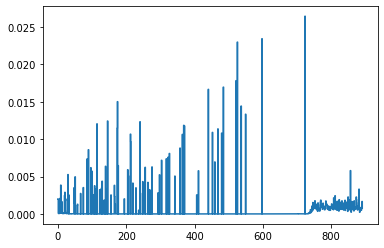

In [78]:
plt.step(range(892), deep_hit_predictions[1], where="post", label=str(1))

In [77]:
deep_hit_predictions[5][8]

0.0024337883

In [95]:
def surv_probability(patient,t):
  return np.sum(predictions[patient][0][t:])

In [90]:
event_times = [  8.,  11.,  16.,  20.,  26.,  27.,  29.,  30.,  31.,  32.,  38.,
        44.,  47.,  50.,  56.,  74.,  76.,  79.,  89.,  96.,  99., 101.,
       105., 109., 112., 114., 118., 120., 122., 125., 127., 129., 133.,
       134., 135., 139., 143., 145., 148., 152., 154., 155., 165., 166.,
       167., 170., 173., 185., 186., 193., 194., 201., 204., 205., 206.,
       213., 215., 219., 220., 235., 236., 239., 241., 248., 255., 261.,
       263., 264., 267., 271., 275., 278., 285., 287., 292., 293., 297.,
       298., 303., 317., 322., 328., 332., 335., 336., 340., 345., 353.,
       357., 362., 364., 368., 370., 395., 399., 411., 438., 440., 441.,
       459., 462., 468., 482., 484., 489., 491., 511., 525., 536., 547.,
       549., 556., 597.]

In [99]:
surv_probability(0,597)

0.34562907

In [102]:
deep_hit_predictions = {}
for patient in range(312):
  surv_array = np.zeros(np.shape(event_times))
  i = 0
  for time in event_times:
    surv_array[i] = surv_probability(patient,np.int(time))
    i += 1
  deep_hit_predictions[patient] = surv_array

In [ ]:
deep_hit_predictions

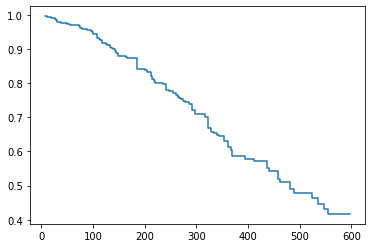

In [104]:
plt.step(event_times, deep_hit_predictions[1], where="post", label=str(1))

In [105]:
deep_hit_predictions['event_times'] = event_times

In [108]:
import pickle
pickle.dump( deep_hit_predictions, open( "patient_surv_functions/deep_hit.p", "wb" ) )

In [110]:
deep_hit_predictions = pickle.load( open( "patient_surv_functions/deep_hit.p", "rb" ) )
print(deep_hit_predictions[0])

[0.97602594 0.96717358 0.95355284 0.94234091 0.92675257 0.9244405
 0.91750813 0.91242731 0.91051555 0.90727079 0.89505213 0.88507223
 0.88002944 0.87186813 0.86114955 0.8357904  0.83045012 0.82405996
 0.81120968 0.80207276 0.79629648 0.79097235 0.78794271 0.77694178
 0.76893604 0.76464844 0.75772178 0.75696939 0.75580412 0.7478587
 0.74366575 0.73939764 0.73311806 0.73283708 0.72857118 0.72399569
 0.71779931 0.71265054 0.70716488 0.70558751 0.70511162 0.70491296
 0.69829142 0.69440997 0.69066381 0.68676567 0.68585706 0.66798365
 0.66774607 0.66617465 0.66601312 0.66087282 0.66037691 0.65542191
 0.65508372 0.64445496 0.63923347 0.63372701 0.62932265 0.62202078
 0.62186491 0.61918736 0.60933143 0.60439444 0.59866118 0.59301484
 0.59263557 0.58779556 0.58339906 0.57868433 0.57360852 0.56848812
 0.56746155 0.56297612 0.55306774 0.55285037 0.54781502 0.54327154
 0.54262376 0.53533965 0.52383137 0.51332808 0.50998843 0.50641108
 0.50629169 0.50077379 0.49548975 0.48891664 0.48846003 0.482270